In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

#importing csv
df = pd.read_csv('data/Heart_Disease_Prediction.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [105]:
#B1 Data Preprocessing
#Convert categorical variables, data cleaning, handle missing values -> Upload preprocessed dataset to GitLab
#Converting Absence/Presnce to Binary Presence Flag
df['Heart Disease'] = (df['Heart Disease'] == 'Presence').astype(int)

df['Heart Disease'].value_counts() # 0 = Absence of HD; 1 = Presene of HD

Heart Disease
0    150
1    120
Name: count, dtype: int64

In [106]:
#Check for null values
df.isnull().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

In [ ]:
#Set 'Heart Disease' as the target column
#B2 Build the algorithm
X = df.drop(columns=['Heart Disease'])
y = df['Heart Disease']

#Split data to training/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#B3 Assigning and train model
rfc_model = RandomForestClassifier(class_weight="balanced", random_state=42)
rfc_model.fit(X_train, y_train)
y_pred = rfc_model.predict(X_test)

#B4 Evaluate model accuracy
#Evaluation metrics - f1score, precision, recall, auc-roc
rfc_f1_score = f1_score(y_test, y_pred)
rfc_precision = precision_score(y_test, y_pred)
rfc_recall = recall_score(y_test, y_pred)
rfc_auc_roc = roc_auc_score(y_test, y_pred)

#Display Base Metrics
print("Base Model Evaluation Metrics")
print("Precision: {:.5f}".format(rfc_precision))
print("Recall: {:.5f}".format(rfc_recall))
print("AUC ROC: {:.5f}".format(rfc_auc_roc))
print("F1 Score: {:.5f}".format(rfc_f1_score))


Base Model Evaluation Metrics
Precision: 0.77778
Recall: 0.66667
AUC ROC: 0.77273
F1 Score: 0.71795


In [ ]:
#B5 Cross-validation
skf_model = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    rfc_model,
    X,
    y,
    cv=skf_model,
    scoring=["precision", "recall", "f1", "roc_auc"]
)

cv_predictions = cross_val_predict(rfc_model, X, y, cv=skf_model, method='predict')

cv_f1_score = f1_score(y, cv_predictions)
cv_precision = precision_score(y, cv_predictions)
cv_recall = recall_score(y, cv_predictions)
cv_auc_roc = roc_auc_score(y, cv_predictions)

print("CV F1 Score: {:.5F}".format(cv_f1_score))
print("CV Precision: {:.5F}".format(cv_precision))
print("CV Recall: {:.5F}".format(cv_recall))
print("CV ROC AUC: {:.5F}".format(cv_auc_roc))


CV F1 Score: 0.77253
CV Precision: 0.79646
CV Recall: 0.75000
CV ROC AUC: 0.79833


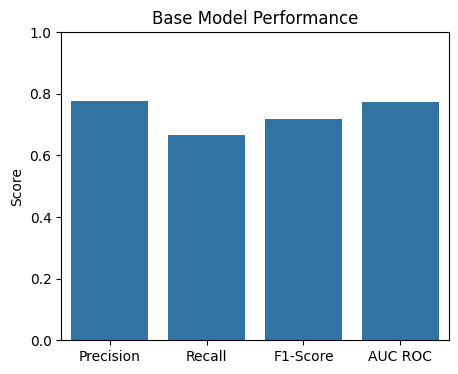

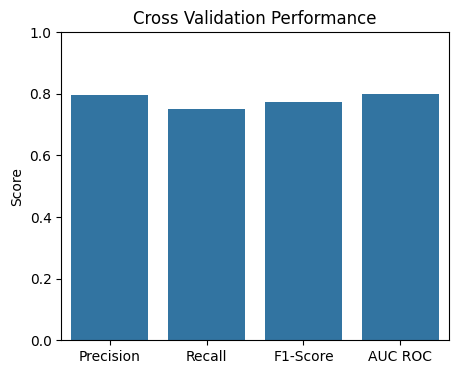

In [ ]:
#Visualize pre vs. post cross validation
base_metrics = {
    "Precision": rfc_precision,
    "Recall": rfc_recall,
    "F1-Score": rfc_f1_score,
    "AUC ROC": rfc_auc_roc
}

cv_metrics = {
    "Precision": cv_precision,
    "Recall": cv_recall,
    "F1-Score": cv_f1_score,
    "AUC ROC": cv_auc_roc 
}

plt.figure(figsize=(5,4))
sns.barplot(data=base_metrics, )
plt.title("Base Model Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(5,4))
sns.barplot(data=cv_metrics)
plt.title("Cross Validation Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


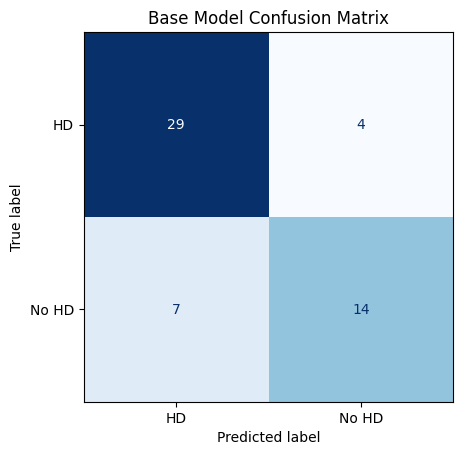

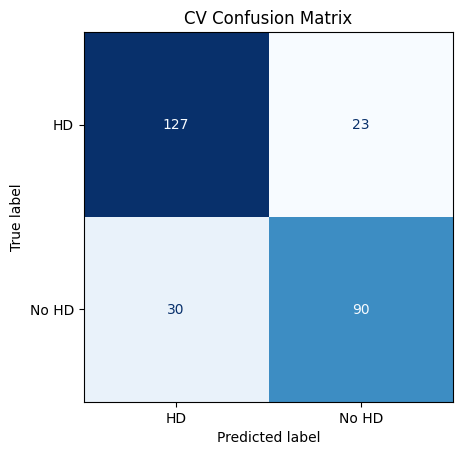

In [115]:
#Confusion matrix
base_cm = confusion_matrix(y_test, y_pred)

base_cm_display = ConfusionMatrixDisplay(confusion_matrix=base_cm, display_labels=["HD", "No HD"])
base_cm_display.plot(cmap="Blues", colorbar=False)
plt.title("Base Model Confusion Matrix")
plt.show()

#CV Confusion Matrix
cv_cm = confusion_matrix(y, cv_predictions)

cv_cm_display = ConfusionMatrixDisplay(confusion_matrix=cv_cm, display_labels=["HD", "No HD"])
cv_cm_display.plot(cmap="Blues", colorbar=False)
plt.title("CV Confusion Matrix")
plt.show()

In [ ]:
#B6 Hyperparameter Tuning
#Hyperparameters to sample from
param_dist = {
    "n_estimators": np.arange(50, 300, 50),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": np.arange(2, 11),
    "min_samples_leaf": np.arange(1, 5),
    "bootstrap": [True, False],
    "class_weight": [None, "balanced"]
}

#Randomized search on the paramater set
rand_search = RandomizedSearchCV(
    estimator=rfc_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=skf_model,
    scoring="f1",
    n_jobs=2,
    random_state=42
)

rand_search.fit(X_train, y_train)

#Printing 
print("Best f1 Score: ", rand_search.best_score_)
print("Best Parameters: ", rand_search.best_params_)



Best f1 Score:  0.7884210526315789
Best Parameters:  {'n_estimators': np.int64(100), 'min_samples_split': np.int64(3), 'min_samples_leaf': np.int64(4), 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': True}


Precision: 0.88235
Recall: 0.71429
F1-Score: 0.78947
AUC ROC: 0.90909
Classification Report
              precision    recall  f1-score   support

  No Disease       0.89      0.73      0.80        33
     Disease       0.67      0.86      0.75        21

    accuracy                           0.78        54
   macro avg       0.78      0.79      0.78        54
weighted avg       0.80      0.78      0.78        54



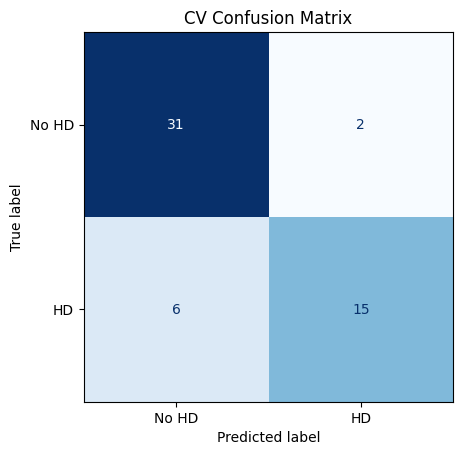

In [125]:
from sklearn.metrics import classification_report
from joblib import dump
#Save model
optimized_model = rand_search.best_estimator_
dump(optimized_model, "heart_disease_predictor.joblib")

#Best model evaluation metrics
best_y_pred = optimized_model.predict(X_test)
best_y_proba = optimized_model.predict_proba(X_test)[:, 1]
best_y_pred_optimized = (best_y_proba >= 0.4).astype(int)

final_metrics = {
    "Precision": precision_score(y_test, best_y_pred),
    "Recall": recall_score(y_test, best_y_pred),
    "F1-Score": f1_score(y_test, best_y_pred),
    "AUC ROC": roc_auc_score(y_test, best_y_proba)
}

#Display results
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.5f}")

#Classification Report
print("Classification Report")
print(classification_report(y_test, best_y_pred_optimized, target_names=["No Disease", "Disease"]))

#Confusion Matrix
cm = confusion_matrix(y_test, best_y_pred)

cv_cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No HD", "HD"])
cv_cm_display.plot(cmap="Blues", colorbar=False)
plt.title("CV Confusion Matrix")
plt.show()

In [ ]:
results